In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import  mean_pinball_loss

import requests
from datetime import datetime, date, timedelta
from tqdm import tqdm

import ephem

In [40]:
# Set start-, forecast-, and end-date here
week = "5"
start_dt = '2019-01-01 00:00:00'        # Data Availability starts here
forecast_dt = '2023-12-13 23:00:00'     # Wednesday/Thursday midnight
forecast_date = '2023-12-13' 
end_dt = '2023-12-16 23:00:00'          # Saturday/Sunday midnight

In [41]:
def get_energy_data():

    # get all available time stamps
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    #ignore first 4 years (don't need those in the baseline and speeds the code up a bit)
    timestamps = list(response.json()["timestamps"])[4*52:]

 
    col_names = ['date_time','Netzlast_Gesamt']
    energydata = pd.DataFrame(columns=col_names)
    
    # loop over all available timestamps
    for stamp in tqdm(timestamps):

        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]

        for i in range(len(rawdata)):

            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")

        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])

    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    #set date_time as index
    energydata.set_index("date_time", inplace=True)
    #resample
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [42]:
# Quantiles
alpha = np.array([.025, .25, .5, .75, .975])

# Create dataframe
df_raw = get_energy_data()
df_raw = df_raw.rename(columns={"Netzlast_Gesamt": "gesamt"})
df_raw['gesamt'] = df_raw['gesamt'] / 1000

  0%|          | 0/275 [00:00<?, ?it/s]C:\Users\Bilal\AppData\Local\Temp\ipykernel_1420\2279548712.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
  4%|▎         | 10/275 [00:01<00:49,  5.40it/s]

100%|██████████| 275/275 [01:01<00:00,  4.49it/s]


In [43]:
# filter data
df = df_raw.copy()
df = df.loc[(df.index >= start_dt) & (df.index <= end_dt)]
df

,gesamt
date_time,
2019-01-01 00:00:00,43.26550
2019-01-01 01:00:00,41.65400
2019-01-01 02:00:00,40.11375
2019-01-01 03:00:00,39.31300
2019-01-01 04:00:00,39.09725
...,...
2023-12-16 19:00:00,55.44150
2023-12-16 20:00:00,52.42600
2023-12-16 21:00:00,50.42925


In [44]:
holidays = pd.read_csv('C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\holidays.csv')
# holidays = np.array(holidays)
holidays.index = pd.to_datetime(holidays['x'])
holidays['date'] = holidays.index.date
holidays

,x,date
x,,
2018-01-01,2018-01-01,2018-01-01
2018-01-06,2018-01-06,2018-01-06
2018-03-30,2018-03-30,2018-03-30
2018-04-02,2018-04-02,2018-04-02
2018-05-01,2018-05-01,2018-05-01
...,...,...
2024-10-31,2024-10-31,2024-10-31
2024-11-01,2024-11-01,2024-11-01
2024-12-24,2024-12-24,2024-12-24


Generate Features, Lag Features, and Daylight Hours

In [45]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['date'] = df.index.date # to join with daylight hours
    return df

In [46]:
def add_lags(df):                       # more lags? yesterday, last week, ...
    target_map = df['gesamt'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364, so we get this day last year on the same weekday
    # df['lag3'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    # df['lag4'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [47]:
# Define the observer location (latitude and longitude for Germany)
latitude = '51.1657'  # Latitude for Germany
longitude = '10.4515'  # Longitude for Germany

# Create an observer object
germany = ephem.Observer()
germany.lat = latitude
germany.lon = longitude

# Set the date for which you want to calculate sunrise time
start_date = df.index.min().date()      # begins at same day as df
end_date =  df.index.max().date()           # + timedelta(days=7)

# Dictionary to store daylight hours for each date
daylight_hours_dict = {}


current_date = start_date
while current_date <= end_date:
    # Set the observer's date
    germany.date = current_date

    # Compute the sunrise time
    sunrise = germany.next_rising(ephem.Sun())
    sunset = germany.next_setting(ephem.Sun())

    daylight_hours = (sunset - sunrise) * 24  # Convert from days to hours

    # Store daylight hours for current date in the dictionary
    daylight_hours_dict[current_date] = daylight_hours
    # Move to next dax
    current_date += timedelta(days=1)

# Print daylight hours for each date
for date, daylight_hours in daylight_hours_dict.items():
    print(f"{date}: Daylight: {daylight_hours:.2f} hours")

2019-01-01: Daylight: 8.00 hours
2019-01-02: Daylight: 8.02 hours
2019-01-03: Daylight: 8.04 hours
2019-01-04: Daylight: 8.06 hours
2019-01-05: Daylight: 8.09 hours
2019-01-06: Daylight: 8.11 hours
2019-01-07: Daylight: 8.14 hours
2019-01-08: Daylight: 8.17 hours
2019-01-09: Daylight: 8.20 hours
2019-01-10: Daylight: 8.23 hours
2019-01-11: Daylight: 8.26 hours
2019-01-12: Daylight: 8.30 hours
2019-01-13: Daylight: 8.33 hours
2019-01-14: Daylight: 8.37 hours
2019-01-15: Daylight: 8.41 hours
2019-01-16: Daylight: 8.45 hours
2019-01-17: Daylight: 8.49 hours
2019-01-18: Daylight: 8.53 hours
2019-01-19: Daylight: 8.57 hours
2019-01-20: Daylight: 8.62 hours
2019-01-21: Daylight: 8.66 hours
2019-01-22: Daylight: 8.71 hours
2019-01-23: Daylight: 8.75 hours
2019-01-24: Daylight: 8.80 hours
2019-01-25: Daylight: 8.85 hours
2019-01-26: Daylight: 8.90 hours
2019-01-27: Daylight: 8.95 hours
2019-01-28: Daylight: 9.00 hours
2019-01-29: Daylight: 9.06 hours
2019-01-30: Daylight: 9.11 hours
2019-01-31

In [48]:
# # Short test
# germany.date = df.index.min().date()
# print(germany.next_rising(ephem.Sun()))
# print(df.index.min().date())

In [49]:
# Convert daylight_hours_dict to a DataFrame for easier manipulation
daylight_df = pd.DataFrame.from_dict(daylight_hours_dict, orient='index', columns=['daylight']) 
daylight_df
# Following steps only relevant for working version (unknown future)
# daylight_df_train = daylight_df.iloc[daylight_df.index < df.index.max().date()]
# Merge df and daylight_df for the observed data
# df = pd.merge(df, daylight_df_train, left_on='date', right_index=True)
# df

,daylight
2019-01-01,7.999110
2019-01-02,8.018310
2019-01-03,8.039151
2019-01-04,8.061609
2019-01-05,8.085658
...,...
2023-12-12,7.982840
2023-12-13,7.966822
2023-12-14,7.952494
2023-12-15,7.939877


In [50]:
df = create_features(df)
df = add_lags(df)
df = pd.merge(df, daylight_df, left_on='date', right_index=True)
df['isHoliday'] = 0
# Mark holidays as 1
df.loc[df['date'].isin(holidays['date']), 'isHoliday'] = 1

df_train = df.loc[df.index <= forecast_dt]

df_test = df.loc[df.index > forecast_dt]


In [51]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2', 'lag3', 'daylight', 'isHoliday']                                              
TARGET = 'gesamt'

X_all = df_train[FEATURES]
y_all = df_train[TARGET]

X_all

,dayofyear,hour,dayofweek,quarter,month,year,lag1,lag2,lag3,daylight,isHoliday
date_time,,,,,,,,,,,
2019-01-01 00:00:00,1,0,1,1,1,2019,NaN,NaN,NaN,7.999110,1
2019-01-01 01:00:00,1,1,1,1,1,2019,NaN,NaN,NaN,7.999110,1
2019-01-01 02:00:00,1,2,1,1,1,2019,NaN,NaN,NaN,7.999110,1
2019-01-01 03:00:00,1,3,1,1,1,2019,NaN,NaN,NaN,7.999110,1
2019-01-01 04:00:00,1,4,1,1,1,2019,NaN,NaN,NaN,7.999110,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13 19:00:00,347,19,2,4,12,2023,68.32100,69.20450,68.76425,7.966822,0
2023-12-13 20:00:00,347,20,2,4,12,2023,64.20250,65.49200,65.01850,7.966822,0
2023-12-13 21:00:00,347,21,2,4,12,2023,61.00975,61.90850,61.82325,7.966822,0


In [52]:
# Train on all data
# Model with hyperparameters from tuning in 00_gradboost.ipynb
reg = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=200,
                       objective = 'reg:quantileerror',        
                       quantile_alpha = alpha,                 
                       max_depth=3,
                       learning_rate=0.1)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-quantile:3.73083
[100]	validation_0-quantile:0.50693
[199]	validation_0-quantile:0.45057


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, objective='reg:quantileerror', ...)

In [53]:
# Save model
reg.save_model('model.json')

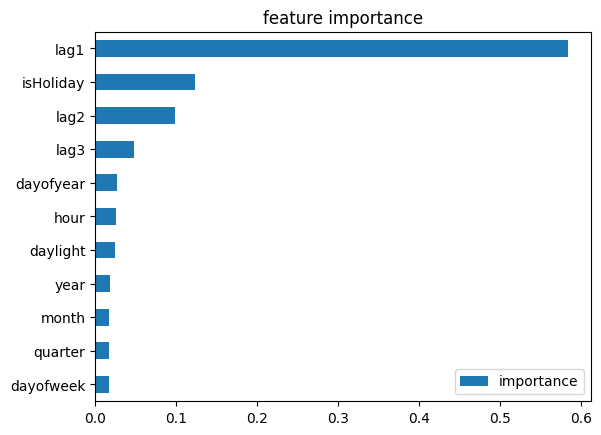

In [54]:
# Feature Importances
reg.feature_importances_
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])
fi.sort_values('importance').plot(kind = 'barh', title = 'feature importance')
plt.show()


In [55]:
# Model parameters
model_params = reg.get_params()
print(model_params)

{'objective': 'reg:quantileerror', 'base_score': None, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'quantile_alpha': array([0.025, 0.25 , 0.5  , 0.75 , 0.975])}


In [56]:
# Tree Structure

Forecast

In [57]:
## Following code only relevant if future unknown 
# Create future dataframe
# future = pd.date_range('2024-03-19', '2025-03-15', freq='1h')
# future_df = pd.DataFrame(index=future)
# future_df['isFuture'] = True
# df['isFuture'] = False
# df_and_future = pd.concat([df, future_df])
# df_and_future = create_features(df_and_future)
# df_and_future = add_lags(df_and_future)
# df_and_future

# df_and_future.drop('daylight', axis=1, inplace=True) # delete daylight column 
# df_and_future = pd.merge(df_and_future, daylight_df, left_on='date', right_index=True) # add daylight column including future values to df
# df_and_future#
df_test


,gesamt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date,lag1,lag2,lag3,daylight,isHoliday
date_time,,,,,,,,,,,,,,,
2023-12-14 00:00:00,48.63725,0,3,4,12,2023,348,14,50,2023-12-14,52.52750,53.19175,54.77550,7.952494,0
2023-12-14 01:00:00,46.49975,1,3,4,12,2023,348,14,50,2023-12-14,50.44450,51.35650,52.77075,7.952494,0
2023-12-14 02:00:00,45.27100,2,3,4,12,2023,348,14,50,2023-12-14,49.47175,50.62850,51.28300,7.952494,0
2023-12-14 03:00:00,45.49475,3,3,4,12,2023,348,14,50,2023-12-14,49.75975,50.43400,51.33300,7.952494,0
2023-12-14 04:00:00,46.83950,4,3,4,12,2023,348,14,50,2023-12-14,51.19200,51.58375,52.45100,7.952494,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-16 19:00:00,55.44150,19,5,4,12,2023,350,16,50,2023-12-16,58.40375,58.72675,60.40575,7.928988,0
2023-12-16 20:00:00,52.42600,20,5,4,12,2023,350,16,50,2023-12-16,55.07050,55.85850,57.45175,7.928988,0
2023-12-16 21:00:00,50.42925,21,5,4,12,2023,350,16,50,2023-12-16,52.38400,53.36425,55.55150,7.928988,0


In [58]:
future_w_features = df_test.copy()

future_w_features['q0.025'] = reg.predict(future_w_features[FEATURES])[:,0]
future_w_features['q0.25'] = reg.predict(future_w_features[FEATURES])[:,1]
future_w_features['q0.5'] = reg.predict(future_w_features[FEATURES])[:,2]
future_w_features['q0.75'] = reg.predict(future_w_features[FEATURES])[:,3]
future_w_features['q0.975'] = reg.predict(future_w_features[FEATURES])[:,4]

future_w_features

,gesamt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date,lag1,lag2,lag3,daylight,isHoliday,q0.025,q0.25,q0.5,q0.75,q0.975
date_time,,,,,,,,,,,,,,,,,,,,
2023-12-14 00:00:00,48.63725,0,3,4,12,2023,348,14,50,2023-12-14,52.52750,53.19175,54.77550,7.952494,0,46.712994,49.558998,50.877449,51.929348,56.629791
2023-12-14 01:00:00,46.49975,1,3,4,12,2023,348,14,50,2023-12-14,50.44450,51.35650,52.77075,7.952494,0,45.058029,47.401039,48.119572,49.737423,54.589794
2023-12-14 02:00:00,45.27100,2,3,4,12,2023,348,14,50,2023-12-14,49.47175,50.62850,51.28300,7.952494,0,44.146751,46.585495,47.662479,49.244122,54.104332
2023-12-14 03:00:00,45.49475,3,3,4,12,2023,348,14,50,2023-12-14,49.75975,50.43400,51.33300,7.952494,0,44.150398,46.720478,47.662479,49.244122,53.979370
2023-12-14 04:00:00,46.83950,4,3,4,12,2023,348,14,50,2023-12-14,51.19200,51.58375,52.45100,7.952494,0,45.383656,48.263214,48.775501,50.954067,55.276085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-16 19:00:00,55.44150,19,5,4,12,2023,350,16,50,2023-12-16,58.40375,58.72675,60.40575,7.928988,0,54.294094,57.041111,58.100792,58.212746,61.615009
2023-12-16 20:00:00,52.42600,20,5,4,12,2023,350,16,50,2023-12-16,55.07050,55.85850,57.45175,7.928988,0,50.695816,53.671711,54.800041,54.716267,59.341064
2023-12-16 21:00:00,50.42925,21,5,4,12,2023,350,16,50,2023-12-16,52.38400,53.36425,55.55150,7.928988,0,48.017391,50.717484,51.816093,52.655178,55.835194


FORECAST EVALUATION

Graphical

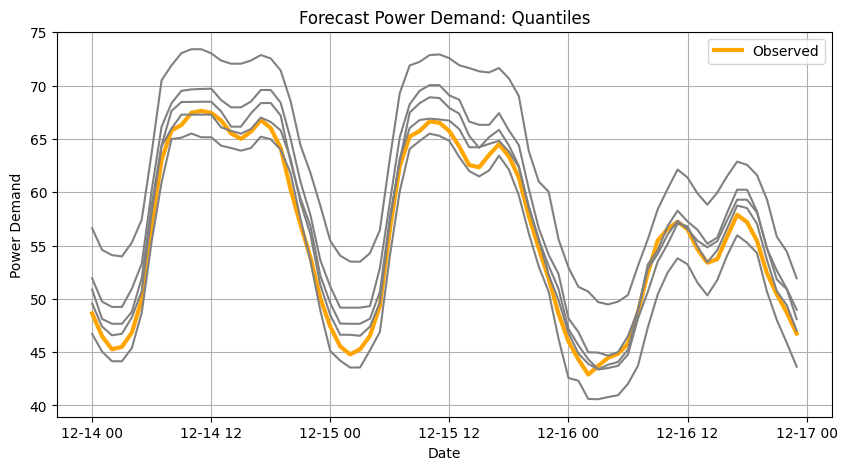

In [59]:
plt.figure(figsize=(10,5))

plt.plot(future_w_features.index, future_w_features['gesamt'], label= 'Observed', lw=3, color='orange')

for column in [ 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']:
    plt.plot(future_w_features.index, future_w_features[column], color='gray') # label = column
    
plt.xlabel('Date')
plt.ylabel('Power Demand')
plt.title('Forecast Power Demand: Quantiles')
plt.legend()
plt.grid(True)
plt.show()

Quantile Score

In [60]:
def quantile_loss(alpha, true, pred):
    return 2 * alpha * (true - pred) if true > pred else 2* (1 - alpha) * (pred - true)

In [61]:
mean_pinball_loss(y_true=future_w_features['gesamt'], y_pred=future_w_features['q0.025'], alpha = alpha[0])

0.07658253848817616

In [62]:
FOREVAL = ['gesamt', 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']

df_foreval = future_w_features[FOREVAL].copy()

In [63]:
quantile_loss(alpha = alpha[0], true = df_foreval.iloc[0,0], pred = df_foreval.iloc[0, 1])

0.09621281890869149

In [64]:
quantile_loss(alpha = alpha[4], true = df_foreval.iloc[len(df_foreval)-1,0], pred = df_foreval.iloc[len(df_foreval)-1, 4+1])

0.25907734527587917

In [65]:
losses = []
# Iterate over alphas
for a in range(len(alpha)):
    # Initialize a list to store losses for current alpha
    alpha_losses = []
    
    # Iterate over rows
    for i in range(len(df_foreval)):
        loss = quantile_loss(alpha = alpha[a], true = df_foreval.iloc[i,0], pred = df_foreval.iloc[i, a+1])
        alpha_losses.append(loss)
        
    # Append the losses for current alpha to the main losses list
    losses.append(alpha_losses)
    
# Convert losses to a DataFrame
losses_df = pd.DataFrame(losses).T

QUANTILESCORES = ['qs0.025', 'qs0.25', 'qs0.5', 'qs0.75', 'qs0.975']
losses_df.columns = QUANTILESCORES
losses_df.index = df_foreval.index
losses_df

,qs0.025,qs0.25,qs0.5,qs0.75,qs0.975
date_time,,,,,
2023-12-14 00:00:00,0.096213,1.382622,2.240199,1.646049,0.399627
2023-12-14 01:00:00,0.072086,1.351934,1.619822,1.618836,0.404502
2023-12-14 02:00:00,0.056212,1.971742,2.391479,1.986561,0.441667
2023-12-14 03:00:00,0.067218,1.838592,2.167729,1.874686,0.424231
2023-12-14 04:00:00,0.072792,2.135571,1.936001,2.057284,0.421829
...,...,...,...,...,...
2023-12-16 19:00:00,0.057370,2.399416,2.659292,1.385623,0.308675
2023-12-16 20:00:00,0.086509,1.868566,2.374041,1.145133,0.345753
2023-12-16 21:00:00,0.120593,0.432350,1.386843,1.112964,0.270297


In [66]:

# average quantile loss
losses_df['mean_qs'] = losses_df.mean(axis=1)
losses_df['sum_qs'] = losses_df.sum(axis=1)
losses_df


,qs0.025,qs0.25,qs0.5,qs0.75,qs0.975,mean_qs,sum_qs
date_time,,,,,,,
2023-12-14 00:00:00,0.096213,1.382622,2.240199,1.646049,0.399627,1.152942,6.917652
2023-12-14 01:00:00,0.072086,1.351934,1.619822,1.618836,0.404502,1.013436,6.080616
2023-12-14 02:00:00,0.056212,1.971742,2.391479,1.986561,0.441667,1.369532,8.217194
2023-12-14 03:00:00,0.067218,1.838592,2.167729,1.874686,0.424231,1.274491,7.646947
2023-12-14 04:00:00,0.072792,2.135571,1.936001,2.057284,0.421829,1.324696,7.948173
...,...,...,...,...,...,...,...
2023-12-16 19:00:00,0.057370,2.399416,2.659292,1.385623,0.308675,1.362075,8.172452
2023-12-16 20:00:00,0.086509,1.868566,2.374041,1.145133,0.345753,1.164001,6.984004
2023-12-16 21:00:00,0.120593,0.432350,1.386843,1.112964,0.270297,0.664610,3.987657


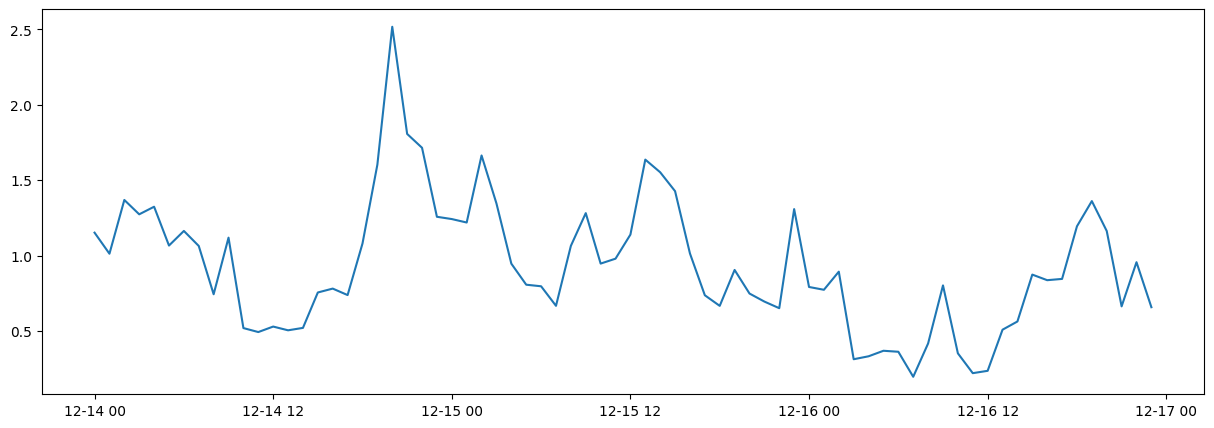

In [67]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(losses_df.index, losses_df['mean_qs'])
plt.show()


Relevant Hours

In [68]:
# 36, 40, 44, 60, 64, 68
# Friday and Saturday: 12, 16, 20 
df_sub = future_w_features.loc[future_w_features.dayofweek.isin([4, 5])].copy()
df_sub = df_sub.loc[df_sub.hour.isin([12,16,20])]
df_sub

,gesamt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date,lag1,lag2,lag3,daylight,isHoliday,q0.025,q0.25,q0.5,q0.75,q0.975
date_time,,,,,,,,,,,,,,,,,,,,
2023-12-15 12:00:00,65.73600,12,4,4,12,2023,349,15,50,2023-12-15,70.05925,70.81575,68.80900,7.939877,0,64.822388,66.718460,67.902077,69.082397,72.576622
2023-12-15 16:00:00,63.50375,16,4,4,12,2023,349,15,50,2023-12-15,67.02425,68.49775,66.96425,7.939877,0,62.043129,64.535233,65.161354,66.324615,71.239235
2023-12-15 20:00:00,57.80150,20,4,4,12,2023,349,15,50,2023-12-15,60.31000,62.59625,61.90600,7.939877,0,56.159092,58.705257,58.539379,60.338543,63.885464
2023-12-16 12:00:00,56.53375,12,5,4,12,2023,350,16,50,2023-12-16,57.28000,60.73000,61.05350,7.928988,0,53.243286,56.804943,56.543743,57.262680,61.382187
2023-12-16 16:00:00,55.85600,16,5,4,12,2023,350,16,50,2023-12-16,57.68125,59.67550,60.12375,7.928988,0,54.086773,56.630585,57.389099,58.103363,61.516598
2023-12-16 20:00:00,52.42600,20,5,4,12,2023,350,16,50,2023-12-16,55.07050,55.85850,57.45175,7.928988,0,50.695816,53.671711,54.800041,54.716267,59.341064


In [69]:
losses_sub = create_features(losses_df).copy()
losses_sub = losses_sub.loc[losses_sub.dayofweek.isin([4, 5])]
losses_sub = losses_sub.loc[losses_sub.hour.isin([12,16,20])]
losses_sub = losses_sub.iloc[:, 0:7]
losses_sub


,qs0.025,qs0.25,qs0.5,qs0.75,qs0.975,mean_qs,sum_qs
date_time,,,,,,,
2023-12-15 12:00:00,0.045681,1.473690,2.166077,1.673199,0.342031,1.140135,6.840813
2023-12-15 16:00:00,0.073031,1.547224,1.657604,1.410433,0.386774,1.015013,6.090079
2023-12-15 20:00:00,0.082120,1.355636,0.737879,1.268521,0.304198,0.749671,4.498026
2023-12-16 12:00:00,0.164523,0.406790,0.009993,0.364465,0.242422,0.237639,1.425831
2023-12-16 16:00:00,0.088461,1.161877,1.533099,1.123682,0.283030,0.838030,5.028179
2023-12-16 20:00:00,0.086509,1.868566,2.374041,1.145133,0.345753,1.164001,6.984004


Create Submission

In [70]:
date_str = datetime.strptime(forecast_date, "%Y-%m-%d")
date_str = date_str.strftime('%Y%m%d')
date_str

'20231213'

In [71]:
df_sub['q0.025'].values

array([64.82239 , 62.04313 , 56.159092, 53.243286, 54.086773, 50.695816],
      dtype=float32)

In [72]:
horizons_def = [36, 40, 44, 60, 64, 68]#[24 + 12*i for i in range(5)]
sub = pd.DataFrame({
    "forecast_date": date_str,
    "target": "energy",
    "horizon": [str(h) + " hour" for h in horizons_def],
    "q0.025": df_sub['q0.025'].values,
    "q0.25": df_sub['q0.25'].values,
    "q0.5": df_sub['q0.5'].values,
    "q0.75": df_sub['q0.75'].values,
    "q0.975": df_sub['q0.975'].values})
sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,20231213,energy,36 hour,64.822388,66.718460,67.902077,69.082397,72.576622
1,20231213,energy,40 hour,62.043129,64.535233,65.161354,66.324615,71.239235
2,20231213,energy,44 hour,56.159092,58.705257,58.539379,60.338543,63.885464
3,20231213,energy,60 hour,53.243286,56.804943,56.543743,57.262680,61.382187
4,20231213,energy,64 hour,54.086773,56.630585,57.389099,58.103363,61.516598
5,20231213,energy,68 hour,50.695816,53.671711,54.800041,54.716267,59.341064


In [73]:
# Save submission
# PATH = "working/energy"

sub.to_csv("C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\power\\gradboost\\results\\powerGB_subQuantiles_week" + week + ".csv", index=False)

In [74]:
# Save quantile scores for submission data
losses_sub.to_csv("C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\power\\gradboost\\results\\powerGB_subQS_week" + week+ ".csv", index=True)

In [75]:
# Save data for all predictions
data = pd.DataFrame({
    "forecast_date": date_str,
    "target": "energy",
    "date_time": future_w_features.index.values,
    "q0.025": future_w_features['q0.025'].values,
    "q0.25": future_w_features['q0.25'].values,
    "q0.5": future_w_features['q0.5'].values,
    "q0.75": future_w_features['q0.75'].values,
    "q0.975": future_w_features['q0.975'].values})

data.to_csv("C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\power\\gradboost\\results\\powerGB_quantiles_week" + week + ".csv", index=False)

In [76]:
# Save quantile score for all predictions
losses_df.to_csv("C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\power\\gradboost\\results\\powerGB_qs_week" + week+ ".csv", index=True)